---

#Human versus AI Distinguishment

##Group 2 - AAI-590: Capstone Project

##Jason Raimondi, Shane Schipper, and Jeremy Cryer

##2024-04-15

###Pretrained_Model.ipynb

###Data Source:

Kaggle - AI Vs Human Text

https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text

###GitHub Repository:

https://github.com/jeraimondi/aai-capstone-ai-content-detector

---

# Environment Prep

## Install Required Packages

In [ ]:
!pip install transformers
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00


## Load Required Libraries

In [ ]:
import math # mathematical functions
import matplotlib.pyplot as plt # plotting
import numpy as np # array manipulation
import pandas as pd # data analysis
import random # random number generator
import seaborn as sns # visualizations
import torch # machine learning framework
import torch.nn as nn # neural networks
import torch.nn.functional as F # neural network functions
from google.colab import drive # connect to drive storage
from sklearn.model_selection import train_test_split # splitter function
from sklearn.utils import resample # resample dataset to balance classes
from torch.utils.data import DataLoader # create DataLoaders
from torch.utils.data import Dataset # create Torch datasets

# binary metrics
from torcheval.metrics import BinaryAccuracy
from torcheval.metrics import BinaryConfusionMatrix
from torcheval.metrics import BinaryF1Score
from torcheval.metrics import BinaryPrecision
from torcheval.metrics import BinaryRecall

from transformers import DistilBertConfig, DistilBertTokenizer # DistilBERT
from transformers import DistilBertForSequenceClassification # DistilBERT
from tqdm import tqdm # progress bars

## Set Random Seeds

In [ ]:
# set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)

## Verify GPU Availability

In [ ]:
# set device for GPU/CPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# verify GPU availability
if device.type == 'cuda':
    print('GPU is available!')
    print('-----------------')
    current_device = torch.cuda.current_device()
    print('Current Device:', current_device)
    print('Device Name:', torch.cuda.get_device_name(current_device))
else:
    raise SystemError('GPU device not found!')

GPU is available!
-----------------
Current Device: 0
Device Name: Tesla V100-SXM2-16GB


# Dataset Prep

## Upload Dataset

In [ ]:
# connect google drive
drive.mount('/content/drive') # uncomment to mount google drive

# read csv file into dataframe
ai_df = pd.read_csv('drive/MyDrive/AI_Human.csv')

# display dataframe
ai_df = ai_df[:200000] # uncomment for smaller set
ai_df

Mounted at /content/drive


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
199995,"Dear Principal,\n\nI believe that cell phones ...",0.0
199996,"Dear principal,\n\nI think It's unfair to mand...",0.0
199997,"Even during the summer, learning new material ...",0.0
199998,"Hey there, it's me, your average 8th grade stu...",1.0


## Rename Columns

In [ ]:
# rename columns in place
ai_df.rename({'text': 'orig_str', 'generated': 'label'}, axis='columns', inplace=True)

# display dataframe
ai_df

,orig_str,label
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
199995,"Dear Principal,\n\nI believe that cell phones ...",0.0
199996,"Dear principal,\n\nI think It's unfair to mand...",0.0
199997,"Even during the summer, learning new material ...",0.0
199998,"Hey there, it's me, your average 8th grade stu...",1.0


## Balance Classes

In [ ]:
# separate classes to support resampling
class_majority = ai_df[ai_df['label'] == 0.0]
class_minority = ai_df[ai_df['label'] == 1.0]

# print class distribution before resampling
print('Class Distribution BEFORE Resampling:')
print('-------------------------------------')
print('Majority Samples (Human - Class 0):', len(class_majority))
print('Minority Samples (AI - Class 1):', len(class_minority))

# resample (downsample) majority class to equal minority class
class_majority_resample = resample(class_majority, replace=False, n_samples=len(class_minority), random_state=0)

# join dataframes
ai_df_balanced = pd.concat([class_minority, class_majority_resample])

# obtain class counts from new dataframe to verify
class_count_human = len(ai_df_balanced[ai_df_balanced['label'] == 0.0])
class_count_ai = len(ai_df_balanced[ai_df_balanced['label'] == 1.0])

# print class distribution after resampling
print('\nClass Distribution AFTER Resampling:')
print('-------------------------------------')
print('Majority Samples (Human - Class 0):', class_count_human)
print('Minority Samples (AI - Class 1):', class_count_ai)

Class Distribution BEFORE Resampling:
-------------------------------------
Majority Samples (Human - Class 0): 121518
Minority Samples (AI - Class 1): 78482

Class Distribution AFTER Resampling:
-------------------------------------
Majority Samples (Human - Class 0): 78482
Minority Samples (AI - Class 1): 78482


## Build Torch Datasets Class

In [ ]:
# define class to build torch dataset required for pytorch training
class TorchDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        # obtain text and label by index
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        # tokenize text
        tokenized_text = self.tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')

        # obtain input_ids and attention_mask from tokenized text
        input_ids = tokenized_text['input_ids']
        attention_mask = tokenized_text['attention_mask']

        # construct output
        out = {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': label
        }

        return out

## Build and Split Datasets

In [ ]:
# define X and y from our entire balanced dataframe
X = ai_df_balanced['orig_str']
y = ai_df_balanced['label']

# first split dataset into 90% training and 10% testing, shuffle and stratify classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=0, shuffle=True, stratify=y)

# next split resulting training set into 80% training and 20% validation, shuffle and stratify classes
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.20, random_state=0, shuffle=True, stratify=y_train)

# reset indices
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# load pretrained tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', vocab_size=200000)

# define max length for sequences
max_length = 512

# call function to build torch datasets
train_dataset = TorchDataset(X_train, y_train, tokenizer, max_length)
val_dataset = TorchDataset(X_val, y_val, tokenizer, max_length)
test_dataset = TorchDataset(X_test, y_test, tokenizer, max_length)

# print dataset sizes
print('Dataset sizes AFTER splitting:')
print('------------------------------')
print('Train:', len(train_dataset))
print('Val:', len(val_dataset))
print('Test:', len(test_dataset))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

Dataset sizes AFTER splitting:
------------------------------
Train: 113013
Val: 28254
Test: 15697


## Create Dataloaders

In [ ]:
# define custom collate_fn to zero-pad sequences
def collate_fn_padding(batch):

    # obtain input_ids, attention_masks, and labels from batch, convert to torch tensors
    input_ids = [sample['input_ids'] for sample in batch]
    attention_masks = [sample['attention_mask'] for sample in batch]
    labels = torch.tensor([sample['label'] for sample in batch], dtype=torch.float32)

    # pad input sequences to maximum sequence length in batch
    max_length = max(len(input_id) for input_id in input_ids)
    padded_input_id = [F.pad(input=input_id, pad=(0, max_length - len(input_id)), mode='constant', value=0) for input_id in input_ids]
    padded_attention_mask = [F.pad(input=attention_mask, pad=(0, max_length - len(attention_mask)), mode='constant', value=0) for attention_mask in attention_masks]

    # put the tensors together in a single batch
    padded_input_ids = torch.stack(padded_input_id).squeeze()
    padded_attention_masks = torch.stack(padded_attention_mask).squeeze()

    # convert labels to 2d for compatibility
    labels = labels.unsqueeze(1)

    return padded_input_ids, padded_attention_masks, labels

In [ ]:
# create dataloaders for train, val, and test datasets
# specify custom collate_fn
train_dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn_padding, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn_padding, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn_padding, shuffle=True)

### Print Sample Batch Sizes

In [ ]:
# obtain inputs and labels of dataloader sample batches
train_inputs, train_attention_masks, train_labels = next(iter(train_dataloader))
val_inputs, val_attention_masks, val_labels = next(iter(val_dataloader))
test_inputs, test_attention_masks, test_labels = next(iter(test_dataloader))

# print sample batch inputs size
print('Sample Batch Inputs Size:')
print('-------------------------')
print('Train:', train_inputs.size())
print('Val:', val_inputs.size())
print('Test:', test_inputs.size())

# print sample batch labels size
print('\nSample Batch Labels Size:')
print('-------------------------')
print('Train:', train_labels.size())
print('Val:', val_labels.size())
print('Test:', test_labels.size())

Sample Batch Inputs Size:
-------------------------
Train: torch.Size([16, 512])
Val: torch.Size([16, 512])
Test: torch.Size([16, 512])

Sample Batch Labels Size:
-------------------------
Train: torch.Size([16, 1])
Val: torch.Size([16, 1])
Test: torch.Size([16, 1])


# Pretrained DistilBERT

## Load from Pretrained

In [ ]:
# load cased variant from pretrained
pretrained_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased')

# set to device
pretrained_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Review Pretrained DistilBERT Config

In [ ]:
# show model config
config = pretrained_model.config
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.38.2",
  "vocab_size": 28996
}

### Update Pretrained DistilBERT Config

In [ ]:
# update model config
config.hidden_dim = 1024 # reduce from 3072
config.n_layers = 2 # reduce from 6
config.vocab_size = 200000 # increase from 28996
config.seq_classif_dropout = 0.05 # decrease from 0.2

# reinitialize new model with updated configuration
pretrained_model = DistilBertForSequenceClassification(config)

# set to device
pretrained_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(200000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-1): 2 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Model Training

## Define Training Function

In [ ]:
# define training function
def train(
        model,
        save_path,
        train_dataloader,
        val_dataloader,
        num_epochs,
        lr,
        patience
):
    criterion = nn.BCELoss() # binary cross entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # adam optimizer

    # running losses
    train_losses = []
    val_losses = []

    # binary accuracy metric and running accuracies
    metric = BinaryAccuracy(device=device)
    train_accuracies = []
    val_accuracies = []

    # variables to save best model and early stopping
    best_val_accuracy = 0.0 # initial value for comparison
    stalled_training_count = 0 # initialize counter

    # iterate through each epoch
    for epoch in range(num_epochs):

        # reset per-epoch losses and metric
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        metric.reset()

        # training loop
        model.train() # set to train mode

        for inputs, masks, labels in tqdm(train_dataloader, desc='Training'):

            # set tensors to device
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            # one-hot encode labels for model compatibility
            label_indices = labels.squeeze().long()
            encoded_labels = F.one_hot(label_indices, num_classes=2).float()

            # clear gradients
            optimizer.zero_grad()

            # forward pass, obtain predictions
            outputs = model(input_ids=inputs, attention_mask=masks, labels=encoded_labels)

            # apply softmax to have predictions between 0 and 1
            predictions = F.softmax(outputs.logits, dim=1)

            # obtain cross entropy loss from model outputs
            loss = outputs.loss

            # update metric
            metric.update(predictions[:,1].squeeze(), labels.squeeze())

            # backward pass, backpropagation
            loss.backward()

            # model parameter update
            optimizer.step()

            # add loss from current training batch
            epoch_train_loss += loss.item()

        # save running loss and metrics during training
        train_losses.append(epoch_train_loss / len(train_dataloader))
        train_accuracies.append(metric.compute().item())

        # reset metric for validation
        metric.reset()

        # validation loop
        model.eval() # set to eval mode

        # disable gradient computation
        with torch.no_grad():

            for inputs, masks, labels in tqdm(val_dataloader, desc='Validation'):

                # set tensors to device
                inputs = inputs.to(device)
                masks = masks.to(device)
                labels = labels.to(device)

                # one-hot encode labels for model compatibility
                label_indices = labels.squeeze().long()
                encoded_labels = F.one_hot(label_indices, num_classes=2).float()

                # obtain predictions, update metric and val loss
                val_outputs = model(input_ids=inputs, attention_mask=masks, labels=encoded_labels)

                # apply softmax to have predictions between 0 and 1
                val_predictions = F.softmax(val_outputs.logits, dim=1)

                # obtain cross entropy loss from model outputs
                val_loss = val_outputs.loss

                # update metric
                metric.update(val_predictions[:,1].squeeze(), labels.squeeze())

                # add loss from current validation batch
                epoch_val_loss += val_loss.item()

            # save running loss and metrics during validation
            val_losses.append(epoch_val_loss / len(val_dataloader))
            val_accuracies.append(metric.compute().item())

        # print results after every specified epochs
        if epoch % 1 == 0:
            print(
                ('\nEpoch {}/{} Results --- train_loss: {:.4f} --- train_acc: {:.4f}'
                ' --- val_loss: {:.4f} --- val_acc: {:.4f}\n').format(
                    epoch + 1,
                    num_epochs,
                    train_losses[-1],
                    train_accuracies[-1],
                    val_losses[-1],
                    val_accuracies[-1]
                )
            )

        # save best model upon val accuracy increase
        # otherwise, check for early stopping condition
        if val_accuracies[-1] > best_val_accuracy:
            best_val_accuracy = val_accuracies[-1] # update best val accuracy
            torch.save(model, save_path) # save model
            stalled_training_count = 0 # reset counter
        else:
            stalled_training_count += 1 # increment counter

            # check for early stopping
            if stalled_training_count >= patience:
                print('Early stopping...')
                print('Validation accuracy has not improved for {} epochs.'.format(patience))
                return train_losses, val_losses, train_accuracies, val_accuracies # exit training early


    return train_losses, val_losses, train_accuracies, val_accuracies

## Train Model

In [ ]:
# training parameters
save_path = '/content/drive/MyDrive/models/pretrained_model.pt' # save best model
num_epochs = 10 # number of epochs to train
lr = 0.001 # learning rate
patience = 2 # early stop if no improvments for this number of epochs

# train model
train_losses, val_losses, train_accuracies, val_accuracies = train(
    pretrained_model,
    save_path,
    train_dataloader,
    val_dataloader,
    num_epochs,
    lr,
    patience
)

Validation: 100%|██████████| 1766/1766 [09:59<00:00,  2.95it/s]



Epoch 1/10 Results --- train_loss: 0.3427 --- train_acc: 0.8561 --- val_loss: 0.2589 --- val_acc: 0.8906



Validation: 100%|██████████| 1766/1766 [09:16<00:00,  3.17it/s]



Epoch 2/10 Results --- train_loss: 0.2753 --- train_acc: 0.8894 --- val_loss: 0.2365 --- val_acc: 0.9042



Validation: 100%|██████████| 1766/1766 [09:39<00:00,  3.05it/s]



Epoch 3/10 Results --- train_loss: 0.2008 --- train_acc: 0.9216 --- val_loss: 0.1957 --- val_acc: 0.9193



Validation: 100%|██████████| 1766/1766 [09:54<00:00,  2.97it/s]



Epoch 4/10 Results --- train_loss: 0.1659 --- train_acc: 0.9377 --- val_loss: 0.1698 --- val_acc: 0.9386



Validation: 100%|██████████| 1766/1766 [09:58<00:00,  2.95it/s]



Epoch 5/10 Results --- train_loss: 0.1523 --- train_acc: 0.9422 --- val_loss: 0.1474 --- val_acc: 0.9431



Validation: 100%|██████████| 1766/1766 [09:40<00:00,  3.04it/s]



Epoch 6/10 Results --- train_loss: 0.1345 --- train_acc: 0.9500 --- val_loss: 0.1474 --- val_acc: 0.9523



Training:  93%|█████████▎| 6588/7064 [48:23<02:05,  3.80it/s]

## Draw Learning Curves

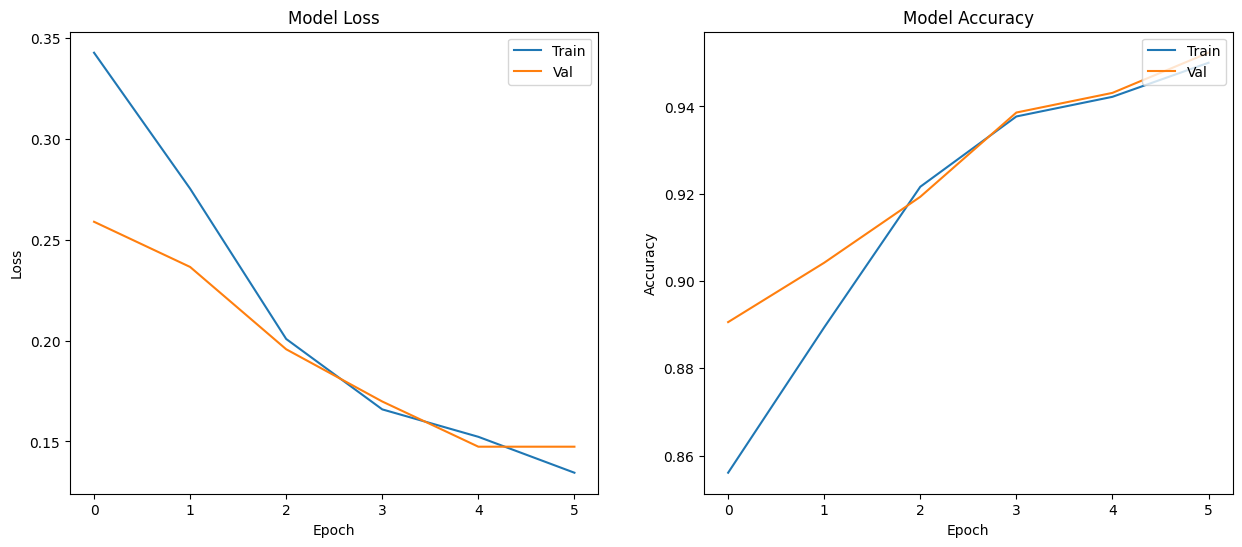

In [ ]:
# define losses/accuracies from previous training
# these were not saved, only provided as output during training
train_loss = [0.3427, 0.2753, 0.2008, 0.1659, 0.1523, 0.1345]
val_loss = [0.2589, 0.2365, 0.1957, 0.1698, 0.1474, 0.1474]
train_acc = [0.8561, 0.8894, 0.9216, 0.9377, 0.9422, 0.9500]
val_acc = [0.8906, 0.9042, 0.9193, 0.9386, 0.9431, 0.9523]

# define function to draw learning curves
def learning_curves(train_loss, val_loss, train_acc, val_acc):

    # create subplots
    plt.subplots(1, 2, figsize=(15, 6))

    # plot model loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')

    # plot model accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')

    # show plot
    plt.show()

# call function to draw learning curves
learning_curves(train_loss, val_loss, train_acc, val_acc)

# Model Evaluation

## Load Model

In [ ]:
# set to True if needing to load model, False otherwise
load_model = True

# path to model to load
model_path = '/content/drive/MyDrive/models/pretrained_model.pt'

# load model
if load_model == True:
    if torch.cuda.is_available():
        pretrained_model = torch.load(model_path) # GPU
    else:
        pretrained_model = torch.load(model_path, map_location=torch.device('cpu')) # CPU

# set model to eval mode
pretrained_model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(200000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-1): 2 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Define Metrics Function

In [ ]:
# define function to get model metrics for val and test datasets
def get_model_metrics(model, dataloader, threshold=0.5):

    # initialize metrics
    metric_ba = BinaryAccuracy(threshold=threshold, device=device)
    metric_bp = BinaryPrecision(threshold=threshold, device=device)
    metric_br = BinaryRecall(threshold=threshold, device=device)
    metric_bf1 = BinaryF1Score(threshold=threshold, device=device)
    metric_bcm = BinaryConfusionMatrix(threshold=threshold, device=device)

    # disable gradient computation
    with torch.no_grad():

        # iterate through each batch
        for inputs, masks, labels in tqdm(dataloader, desc='Obtaining Metrics'):

            # set tensors to device
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            # obtain predictions
            outputs = model(inputs, masks)

            # apply softmax to have predictions between 0 and 1
            predictions = F.softmax(outputs.logits, dim=1)

            # update metric states
            metric_ba.update(predictions[:,1].squeeze(), labels.squeeze())
            metric_bp.update(predictions[:,1].squeeze(), labels.squeeze())
            metric_br.update(predictions[:,1].squeeze(), labels.int().squeeze())
            metric_bf1.update(predictions[:,1].squeeze(), labels.squeeze())
            metric_bcm.update(predictions[:,1].squeeze(), labels.int().squeeze())

    # compute and save metrics
    score_accuracy = metric_ba.compute().item()
    score_precision = metric_bp.compute().item()
    score_recall = metric_br.compute().item()
    score_f1 = metric_bf1.compute().item()
    bcm = metric_bcm.compute()

    # print metrics
    print('\n')
    print('Binary Accuracy:', '{:.2%}'.format(score_accuracy))
    print('Binary Precision:', '{:.2%}'.format(score_precision))
    print('Binary Recall:', '{:.2%}'.format(score_recall))
    print('Binary F1 Score:', '{:.2%}'.format(score_f1))
    print('\nBinary Confusion Matrix:\n', bcm)
    print('\nTrue Positive:', bcm[0][0].int().item())
    print('False Negative:', bcm[0][1].int().item())
    print('False Positive:', bcm[1][0].int().item())
    print('True Negative:', bcm[1][1].int().item())

    return score_accuracy, score_precision, score_recall, score_f1, bcm

## Evaluate on Validation Set

### Obtain Metrics

In [ ]:
# evaluate validation dataset
score_accuracy, score_precision, score_recall, score_f1, bcm = get_model_metrics(pretrained_model, val_dataloader)

Obtaining Metrics: 100%|██████████| 1766/1766 [10:08<00:00,  2.90it/s]




Binary Accuracy: 95.23%
Binary Precision: 92.79%
Binary Recall: 98.07%
Binary F1 Score: 95.36%

Binary Confusion Matrix:
 tensor([[13050.,  1077.],
        [  272., 13855.]], device='cuda:0')

True Positive: 13050
False Negative: 1077
False Positive: 272
True Negative: 13855


### Build Confusion Matrix

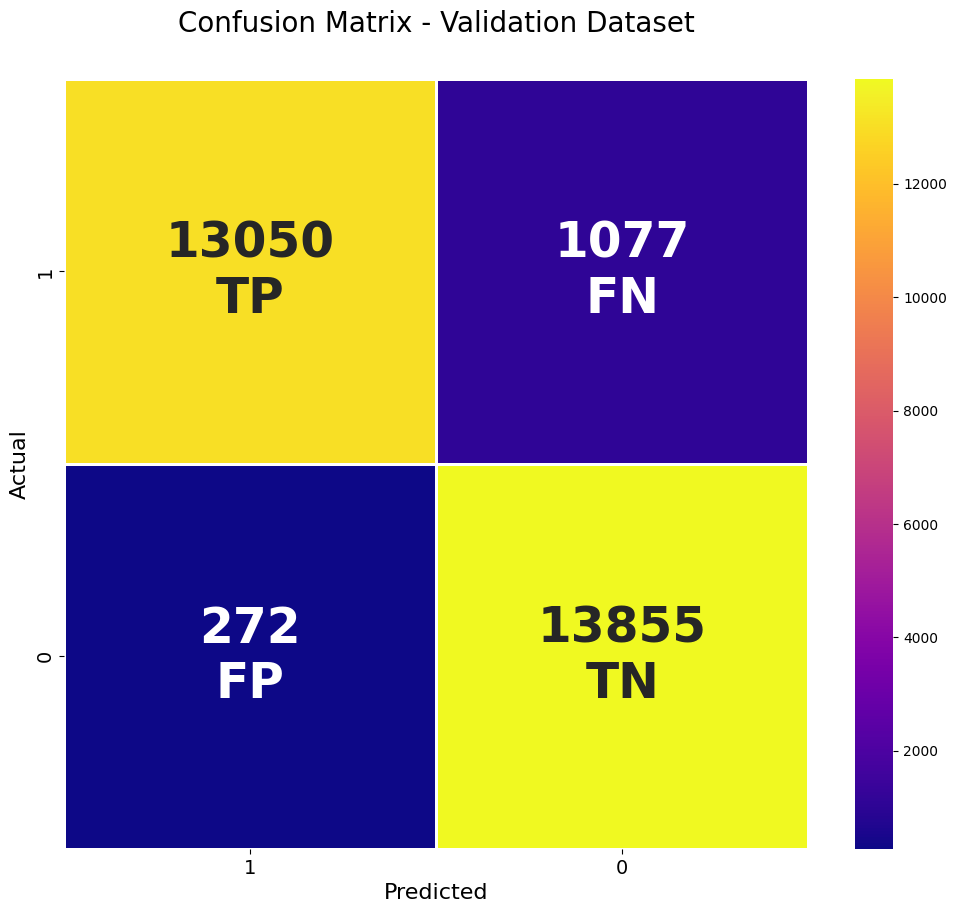

In [ ]:
# combine values with text for annotations
tp = str(bcm[0][0].int().item()) + '\nTP'
fn = str(bcm[0][1].int().item()) + '\nFN'
fp = str(bcm[1][0].int().item()) + '\nFP'
tn = str(bcm[1][1].int().item()) + '\nTN'

# create array with annotations
bcm_annot = np.array([tp, fn, fp, tn]).reshape((2,2))

# build and display confusion matrix
plt.figure(figsize = (12,10))
sns.heatmap(data=bcm.cpu(), annot=bcm_annot, annot_kws={'fontsize': 35, 'fontweight': 'heavy'}, fmt='', linewidths=2, linecolor='white', cmap='plasma')
plt.title('Confusion Matrix - Validation Dataset', y=1.05, fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(ticks=[0.5, 1.5],labels=['1', '0'], fontsize=14)
plt.yticks(ticks=[0.5, 1.5],labels=['1', '0'], fontsize=14)
plt.show()